# Neural Net for Dog Image Recognition

## Environment Setup

Import libraries and mount Drive

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [59]:
%matplotlib inline
import os, cv2
import pandas as pd
import numpy as np
from sklearn import neural_network
import scipy.io as sio
import tarfile
from IPython.display import SVG

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import model_to_dot, plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam,SGD

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re

# for tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-03-24 02:42:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.95.127.176, 52.70.214.4, 52.73.195.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.95.127.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.45MB/s    in 2.0s    

2020-03-24 02:42:16 (6.45 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# define function to keep track of running progress
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 95
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

## Import images

In [34]:
regex_pattern = '[^-]*$'
root_path = 'drive/My Drive/DogApp/data/Images/'

def build_dog_dict(root_path, regex_pattern):
    folder_list = [breed_folder for breed_folder in os.listdir(root_path)]
    breed_list = [re.search(regex_pattern, breed)[0] for breed in os.listdir(root_path)]
    return {'folders': folder_list, 'breeds': breed_list}
dog_dict = build_dog_dict(root_path=root_path, regex_pattern='[^-]*$')


# define function to assign labels to images
def label_assignment(img,label):
    return label

# define function to read in image pixel values and labels
def training_data(label,data_dir):
    for img in os.listdir(data_dir):
        label = label_assignment(img,label)
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

X, Z = [], []
imgsize = 150

# define function to load images into memory
def image_loader(breed_count):
  ticker = 0
  for breed_folder, breed in list(zip(dog_dict['folders'], dog_dict['breeds']))[:breed_count]:
    ticker += 1
    print('\nProcessesing: {}'.format(breed))
    training_data(breed, root_path + breed_folder)
    update_progress(ticker / breed_count)

# load images into memory
image_loader(breed_count = 10)

Progress: [###############################################################################################] 100.0%


In [36]:
len(Z)

1753

In [0]:
# one hot encode the image labels for training
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y,breed_count)
X = np.array(X)
X=X/255

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=24)

In [38]:
x_train.shape

(1227, 150, 150, 3)

In [39]:
len(x_train)

1227

In [40]:
for i in augs_gen.flow(x_train,y_train,batch_size=16)[0]:
    print(i.repeat(repeats=[2], axis=0).shape)

(32, 150, 150, 3)
(32, 25)


In [0]:
# define image generator to generate additional synthetic images
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

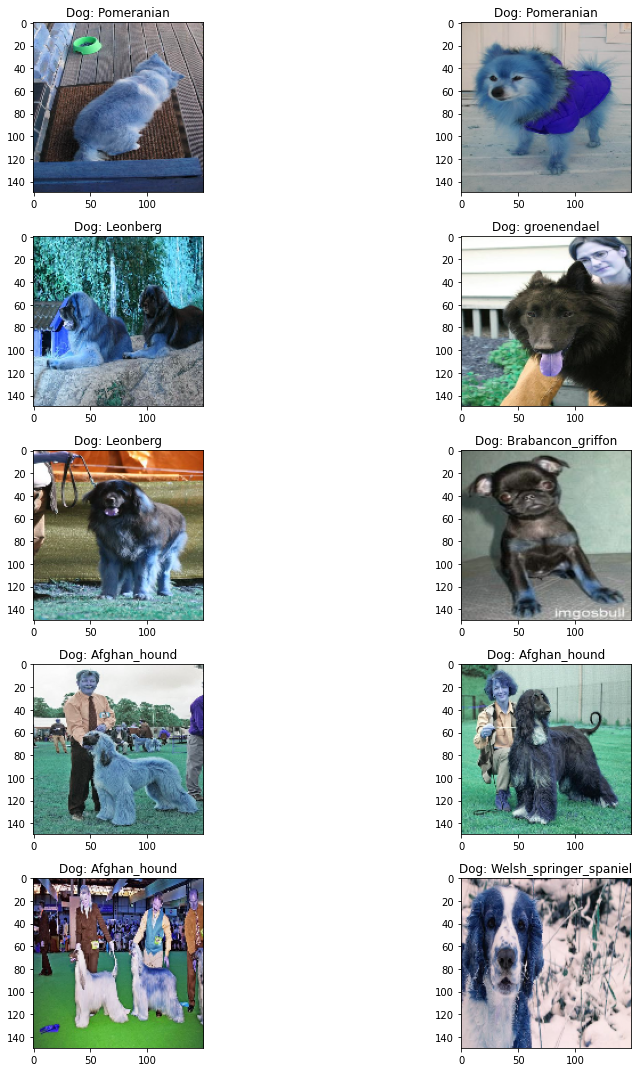

In [42]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+Z[l])
        
plt.tight_layout()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f99202506a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f99202289e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9920228e10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9920260978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9940466860> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9920257240> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f99202573c8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9920242278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9920258c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9920258c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9920237be0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 

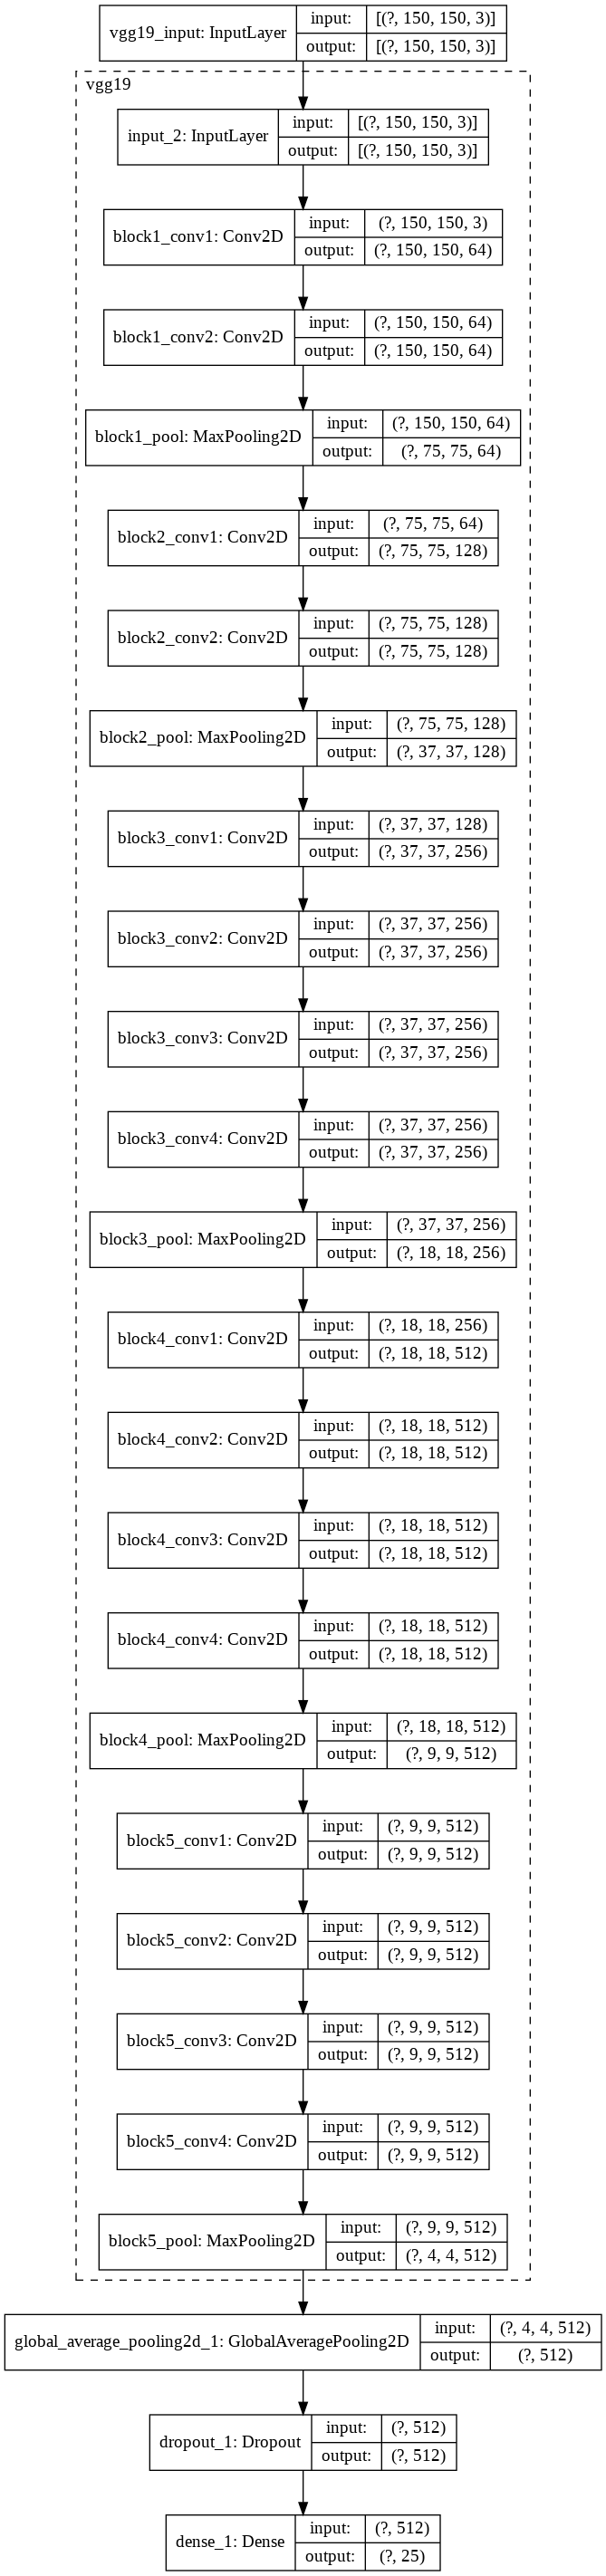

In [43]:
# stable!
base_model = VGG19(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(breed_count,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)


In [66]:
# fire up tensorboard
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
print('Tensorboard started.')

model_path = 'drive/My Drive/DogApp/model/'
checkpoint = ModelCheckpoint(
    filepath = model_path + 'base.model',#'./base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

https://04614fe8.ngrok.io
Tensorboard started.


In [67]:
# stable!
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)
#-----------Training------------#
batch_size = 16
history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=batch_size),#[0][0].repeat(repeats=[2], axis=0),
    validation_data  = (x_test,y_test),
    validation_steps = np.ceil(len(x_test) / batch_size),
    steps_per_epoch  = np.ceil(len(x_train) / batch_size),
    epochs = 3,
    verbose = 1,
    callbacks=callbacks
)

  ...
    to  
  ['...']
Train for 77.0 steps, validate on 526 samples
Epoch 1/3
76/77 [============================>.] - ETA: 0s - loss: 1.2453 - accuracy: 0.5805
Epoch 00001: val_loss improved from inf to 1.00091, saving model to drive/My Drive/DogApp/model/base.model
INFO:tensorflow:Assets written to: drive/My Drive/DogApp/model/base.model/assets
77/77 [==============================] - 9s 122ms/step - loss: 1.2453 - accuracy: 0.5803 - val_loss: 1.0009 - val_accuracy: 0.6996
Epoch 2/3
76/77 [============================>.] - ETA: 0s - loss: 1.2344 - accuracy: 0.5871
Epoch 00002: val_loss did not improve from 1.00091
77/77 [==============================] - 7s 86ms/step - loss: 1.2378 - accuracy: 0.5852 - val_loss: 1.0170 - val_accuracy: 0.6768
Epoch 3/3
76/77 [============================>.] - ETA: 0s - loss: 1.2045 - accuracy: 0.5789
Epoch 00003: val_loss improved from 1.00091 to 0.99534, saving model to drive/My Drive/DogApp/model/base.model
INFO:tensorflow:Assets written to: driv

In [68]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.0
added 35 packages from 21 contributors in 1.73s


SyntaxError: ignored

In [0]:
root_path = 'drive/My Drive/DogApp'

!mkdir -p saved_model
model.save('saved_model/my_model') 

model.save(root_path + './base.model/model.h5')

OSError: ignored

OSError: ignored

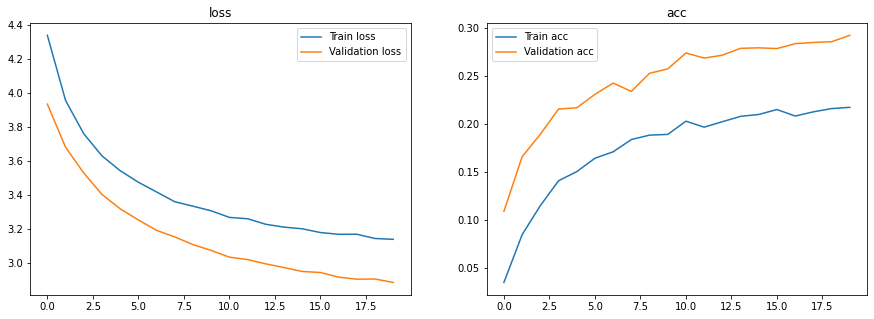

In [0]:
show_final_history(history)
model.load_weights('./base.model')
model_score = model.evaluate(x_test,y_test)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
root_path = 'drive/My Drive/DogApp/'

model.save(root_path + 'model.h5')
print("Weights Saved")

In [0]:
history

## Code Hoarding

In [30]:
'''
image_count = int(input('Enter the number of images you would like to train on: '))
#y_binary = to_categorical(train_labels)

#image_count = 200
model = Sequential()
model.add(Conv1D(120, kernel_size=3, activation='relu', input_shape=(12000,3)))
#model.add(Dense(2000, activation = 'relu', input_shape = (12000,)))
model.add(Flatten())
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(120, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_data[:image_count], train_labels_numeric[:image_count], validation_split = 0.2, epochs = 100)
'''

"\nimage_count = int(input('Enter the number of images you would like to train on: '))\n#y_binary = to_categorical(train_labels)\n\n#image_count = 200\nmodel = Sequential()\nmodel.add(Conv1D(120, kernel_size=3, activation='relu', input_shape=(12000,3)))\n#model.add(Dense(2000, activation = 'relu', input_shape = (12000,)))\nmodel.add(Flatten())\nmodel.add(Dense(250, activation = 'relu'))\nmodel.add(Dense(250, activation = 'relu'))\nmodel.add(Dense(250, activation = 'relu'))\nmodel.add(Dense(250, activation = 'relu'))\nmodel.add(Dense(120, activation = 'softmax'))\nmodel.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])\nmodel.fit(train_data[:image_count], train_labels_numeric[:image_count], validation_split = 0.2, epochs = 100)\n"

In [35]:
# define root path containing images and their data
#root_path = 'drive/My Drive/DogApp/data/Images/'
'''
chihuahua_dir = root_path + '/data/Images/n02085620-Chihuahua'
japanese_spaniel_dir = root_path + '/data/Images/n02085782-Japanese_spaniel'
maltese_dir = root_path + '/data/Images/n02085936-Maltese_dog'
pekinese_dir = root_path + '/data/Images/n02086079-Pekinese'
shitzu_dir = root_path + '/data/Images/n02086240-Shih-Tzu'
blenheim_spaniel_dir = root_path + '/data/Images/n02086646-Blenheim_spaniel'
papillon_dir = root_path + '/data/Images/n02086910-papillon'
toy_terrier_dir = root_path + '/data/Images/n02087046-toy_terrier'
afghan_hound_dir = root_path + '/data/Images/n02088094-Afghan_hound'
basset_dir = root_path + '/data/Images/n02088238-basset'
'''


'''
  breed_folder, breed in zip(dog_dict['folders'], dog_dict['breeds']):
  ticker += 1
  print(breed)
  #print(breed_folder)
  print('Run #{}'.format(ticker))
  #if ticker < 3:
    #print('{}'.format(breed_folder) + ' | ' + '{}'.format(breed))
  training_data(breed, root_path + breed_folder)
  #else:
   # break
'''

"\n  breed_folder, breed in zip(dog_dict['folders'], dog_dict['breeds']):\n  ticker += 1\n  print(breed)\n  #print(breed_folder)\n  print('Run #{}'.format(ticker))\n  #if ticker < 3:\n    #print('{}'.format(breed_folder) + ' | ' + '{}'.format(breed))\n  training_data(breed, root_path + breed_folder)\n  #else:\n   # break\n"

In [0]:
'''
# read in data and append pixel values to X and labels to Z
training_data('chihuahua',chihuahua_dir)
training_data('japanese_spaniel',japanese_spaniel_dir)
training_data('maltese',maltese_dir)
training_data('pekinese',pekinese_dir)
training_data('shitzu',shitzu_dir)
training_data('blenheim_spaniel',blenheim_spaniel_dir)
training_data('papillon',papillon_dir)
training_data('toy_terrier',toy_terrier_dir)
training_data('afghan_hound',afghan_hound_dir)
training_data('basset',basset_dir)
'''

In [0]:
'''
# Define function to download .mat files
def loadMatFile(file_name):
  root_path = 'drive/My Drive/DogApp/'
  return sio.loadmat(root_path + file_name)

# Import train and test sets
train_dict = loadMatFile('train_data.mat')
test_dict = loadMatFile('test_data.mat')
train_data = train_dict['train_data']
test_data = test_dict['test_data']
'''

In [0]:
'''
def extract_labels(regex_pattern, dictionary, return_type):
    label_list = []
    if 'train' in '{}'.format(dictionary):
        prefix = 'train'
        for array in dictionary['{}_info'.format(prefix)][0][0][0]:
            label_list.append(re.search(regex_pattern, array[0][0]).group(1))
    elif 'test' in '{}'.format(dictionary):
        prefix = 'test'
        for array in dictionary['{}_info'.format(prefix)][0][0][0]:
            label_list.append(re.search(regex_pattern, array[0][0]).group(1))
    else:
        print('Error: please check your input dictionary. You may have entered the name of a non-existant dictionary.')
    print('Processed {} {} labels!'.format(len(label_list), prefix))
    if return_type == 'series':
        return pd.Series(label_list)
    elif return_type == 'array':
        return np.asarray(label_list)
    elif return_type == 'list':
        return label_list

train_labels = extract_labels(regex_pattern = '-(.*?)/n', dictionary = train_dict, return_type = 'series')
test_labels = extract_labels(regex_pattern = '-(.*?)/n', dictionary = test_dict, return_type = 'series')

# convert label series containing string labels to numeric lables 
test_labels_numeric, uniques = test_labels.factorize()
train_labels_numeric, uniques = train_labels.factorize()
test_labels_numeric
'''

In [0]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

## Exploratory Data Analysis

In [0]:
train_dict

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Mar 28 12:03:37 2012',
 '__version__': '1.0',
 'train_data': array([[1.        , 0.37021212, 0.38627623, ..., 0.21216631, 0.33752761,
         0.26825407],
        [0.37021212, 1.        , 0.45434285, ..., 0.14359524, 0.3095    ,
         0.17709522],
        [0.38627623, 0.45434285, 1.        , ..., 0.16968838, 0.28702648,
         0.20437348],
        ...,
        [0.21216631, 0.14359524, 0.16968838, ..., 1.        , 0.22314713,
         0.41941136],
        [0.33752761, 0.3095    , 0.28702648, ..., 0.22314713, 1.        ,
         0.31585238],
        [0.26825407, 0.17709522, 0.20437348, ..., 0.41941136, 0.31585238,
         1.        ]]),
 'train_fg_data': array([[4.32900433e-04, 2.88600289e-04, 2.88600289e-04, ...,
         3.96825397e-04, 3.24675325e-04, 2.30880231e-03],
        [0.00000000e+00, 6.34920635e-04, 6.98412698e-04, ...,
         1.90476190e-04, 3.17460317e-05, 4.09523810e-03],

In [0]:
train_data[100].shape

(12000,)

In [0]:
train_data.shape

(12000, 12000)

In [0]:
test_data.shape

(8580, 12000)

In [0]:
test_data[0]

array([0.42297642, 0.44567102, 0.44322268, ..., 0.11023967, 0.28878223,
       0.16612349])

## Model Instantiation

In [0]:
MLPC_nn = neural_network.MLPClassifier()